# Introduction to Interpolation

### Initialization

In [46]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

plt.rcParams['figure.figsize'] = [10, 10]

In [47]:
# convenience function that estimates time per execution
def timer_avg20(func, *args):
    start = time.monotonic()
    for i in range(20):
        func(*args)
    end = time.monotonic()
    return (end-start)/20

# convenience function that estimates the difference between 2 images
def diffscore(img1, img2):
    return np.sum(abs(img1-img2))

In [48]:
# read original image, converting to RGB because that format is expected by matplotlib
src = cv2.cvtColor(cv2.imread("src.jpg"), cv2.COLOR_BGR2RGB)

### Observations

Original size: (200, 200, 3)


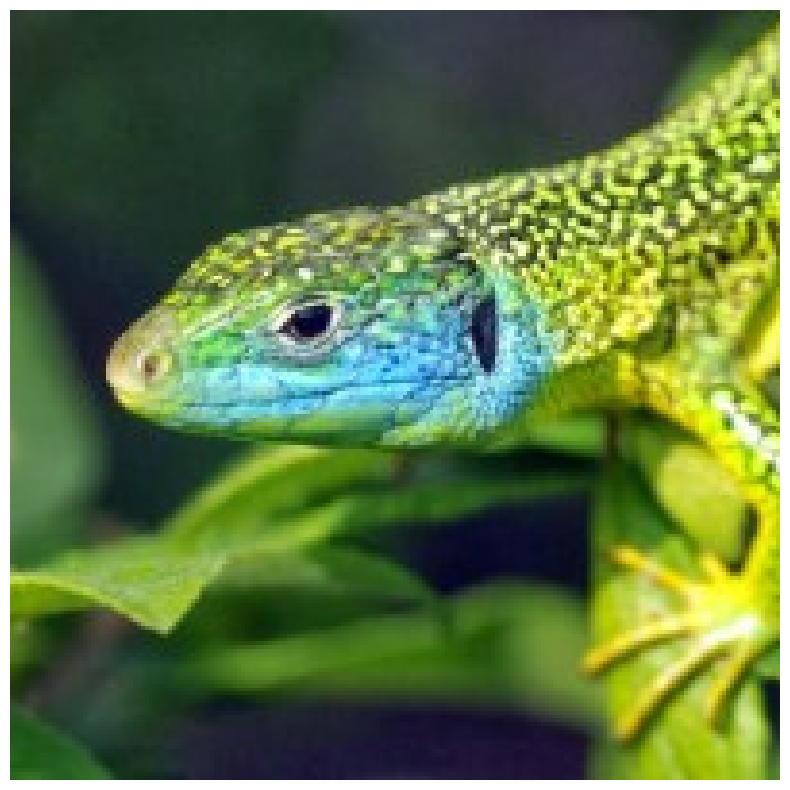

In [49]:
plt.axis("off")
plt.imshow(src)
print(f"Original size: {src.shape}")

As you can see, the image is rather low-res. This lets us observe upscaling artifacts.

In this exercise we consider a few image interpolation algorithms:
 
 * Nearest Neighbour
 * Bilinear
 * Bicubic
 
...as well implement some of them.

--------------------------------------------------
Image shape before interpolation:  (200, 200, 3)
Image shape after interpolation, factor 0.1:  (20, 20, 3)

        INTER_NEAREST              INTER_LINEAR                INTER_CUBIC


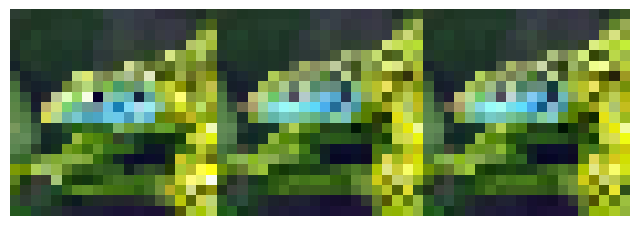

--------------------------------------------------
Image shape before interpolation:  (200, 200, 3)
Image shape after interpolation, factor 0.2:  (40, 40, 3)

        INTER_NEAREST              INTER_LINEAR                INTER_CUBIC


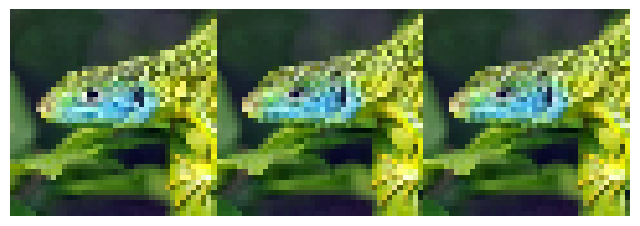

--------------------------------------------------
Image shape before interpolation:  (200, 200, 3)
Image shape after interpolation, factor 0.5:  (100, 100, 3)

        INTER_NEAREST              INTER_LINEAR                INTER_CUBIC


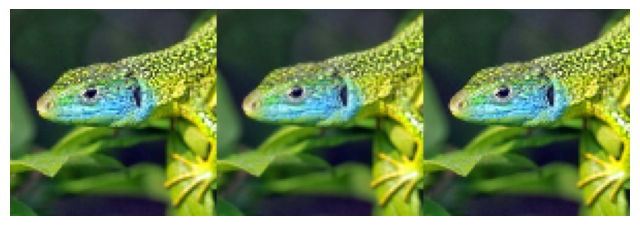

--------------------------------------------------
Image shape before interpolation:  (200, 200, 3)
Image shape after interpolation, factor 2:  (400, 400, 3)

        INTER_NEAREST              INTER_LINEAR                INTER_CUBIC


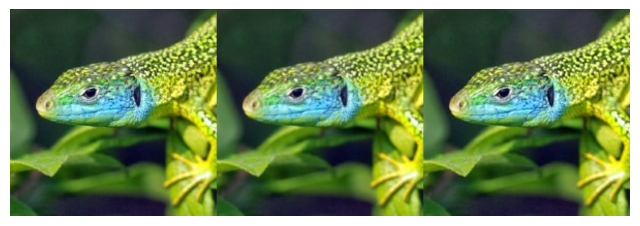

--------------------------------------------------
Image shape before interpolation:  (200, 200, 3)
Image shape after interpolation, factor 4:  (800, 800, 3)

        INTER_NEAREST              INTER_LINEAR                INTER_CUBIC


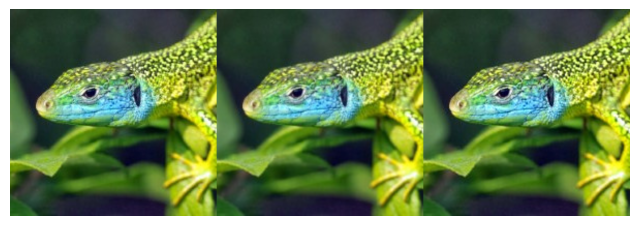

--------------------------------------------------
Image shape before interpolation:  (200, 200, 3)
Image shape after interpolation, factor 10:  (2000, 2000, 3)

        INTER_NEAREST              INTER_LINEAR                INTER_CUBIC


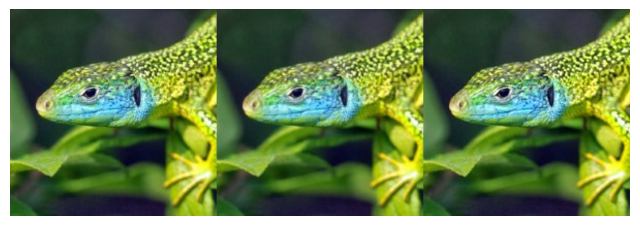

In [50]:
plt.rcParams['figure.figsize'] = [8, 8]

for size_coeff in [0.1, 0.2, 0.5, 2, 4, 10]:
    near_img = cv2.resize(src, None, fx = size_coeff, fy = size_coeff, interpolation = cv2.INTER_NEAREST)
    bilinear_img = cv2.resize(src, None, fx = size_coeff, fy = size_coeff, interpolation = cv2.INTER_LINEAR)
    bicubic_img = cv2.resize(src, None, fx = size_coeff, fy = size_coeff, interpolation = cv2.INTER_CUBIC)
    
    # Concatenating all interpolation images in a single image
    img_concatenated = np.concatenate((near_img, bilinear_img, bicubic_img), axis=1)
    
    print("-"*50)
    print("Image shape before interpolation: ", src.shape)
    print(f"Image shape after interpolation, factor {size_coeff}: ", near_img.shape)
    print(f"\n{' '*8}INTER_NEAREST{' '*14}INTER_LINEAR{' '*16}INTER_CUBIC")
    # Create figure to show original image
    plt.figure()
    plt.axis("off")
    plt.imshow(img_concatenated)
    plt.show()

We will not see much difference between upscaled images here due to Matplotlib downscaling them all with bicubic.

You should try displaying a single upscaled image for a closer look.

### Nearest Neighbour Interpolation

Now, let's try implementing Nearest Neighbour interpolation, aiming for the lowest score (value difference between our function and the cv2 built-in)

In [51]:
def your_nn_func(src, x_coeff, y_coeff):
    (x_ori, y_ori, d_ori) = src.shape # the shape is rows * columns * color channels
    
    ## code here, don't forget to return your glorious resized image ##
    resized = np.full((int(x_ori*x_coeff), int(y_ori*y_coeff), d_ori), 1)
    for rown in range (int(x_ori*x_coeff)):
        for coln in range (int(y_ori*y_coeff)):
            resized[rown][coln] = src[int(rown/x_coeff)][int(coln/y_coeff)]

    return resized

Please describe the algorithm here after the practical (preferrably in your own words):

... In this algorythm we have our target our currently empty new impage of the size of original multiplied by the coeff. than we go through every and each pixel and take their coordinates so that we take the pixel (for exapmle pixel in 2x3 and move it to the corresponding place (4X6))  

Value difference between images: 0


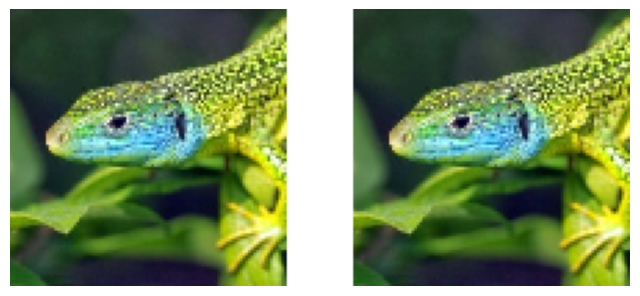

In [52]:
x_coeff, y_coeff = 0.5, 0.5

builtin_nn = cv2.resize(src, None, fx = x_coeff, fy = y_coeff, interpolation = cv2.INTER_NEAREST)
your_nn = your_nn_func(src, x_coeff, y_coeff)

sep_strip = np.full((int(src.shape[0]*x_coeff), 24, 3), 255) # for convenience

result = np.concatenate((builtin_nn, sep_strip, your_nn), axis=1)
plt.axis("off")
plt.imshow(result)

print(f"Value difference between images: {diffscore(builtin_nn, your_nn)}")

How does the builtin and our effort compare in terms of looks? What about speed?

In [53]:
cv2_avg = timer_avg20(cv2.resize, src, None, None, 2, 2, cv2.INTER_NEAREST)
your_avg = timer_avg20(your_nn_func, src, 2, 2)
print(f"The average time per image with cv2 is {cv2_avg}, and {your_avg} with your function")

The average time per image with cv2 is 0.0, and 0.25 with your function


Don't worry, it's almost impossible to even come close to the builtin in terms of speed - the cv2 package is just a wrapper around a C++ library, and C++ is known to be ~40 times faster than modern Python.

### Bilinear Interpolation

Now, try the Bilinear interpolation algorithm

In [54]:
def your_bilin_func(src, x_coeff, y_coeff):
    (x_ori, y_ori, d_ori) = src.shape # the shape is rows * columns * color channels
    
    ## code here, don't forget to return your glorious resized image ##
    x_new = int(x_ori * x_coeff)
    y_new = int(y_ori * y_coeff)
    resized = np.full((int(x_new), int(y_new), d_ori), 1)
    x_scale = float(x_ori - 1) / float(x_new - 1)
    y_scale = float(y_ori - 1) / float(y_new - 1)
    
    for i in range(x_new):
        for j in range(y_new):
            x = i * x_scale
            y = j * y_scale
            
            x_int = int(x)
            y_int = int(y)
            x_dist = x - x_int
            y_dist = y - y_int
            
            c00 = src[x_int, y_int]
            c01 = src[x_int, y_int + 1]
            c10 = src[x_int + 1, y_int]
            c11 = src[x_int + 1, y_int + 1]
            
            val = (1 - x_dist) * (1 - y_dist) * c00 + \
                  x_dist * (1 - y_dist) * c10 + \
                  (1 - x_dist) * y_dist * c01 + \
                  x_dist * y_dist * c11
            
            resized[i, j] = val.astype(np.uint8)
            
    return resized

Please describe the algorithm here after the practical (preferrably in your own words):

... This code takes in the source image and scaling factors (x and y coeff) for the width and height of the resized image, respectively. It calculates the new dimensions of the resized image, creates a new array with those dimensions, and calculates the scale factors to map the old image coordinates to the new image coordinates. It then iterates over the pixels in the resized image, calculates the corresponding coordinates in the original image, calculates the four corner pixels in the original image, and performs bilinear interpolation to calculate the value of the pixel in the resized image. Finally, it sets the pixel value in the resized image and returns it.

Value difference between images: 93866


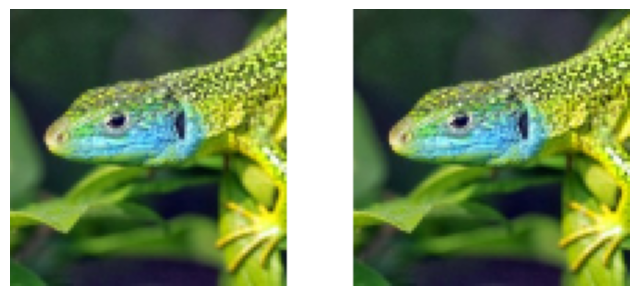

In [55]:
x_coeff, y_coeff = 0.5, 0.5

builtin_bilin = cv2.resize(src, None, fx = x_coeff, fy = y_coeff, interpolation = cv2.INTER_LINEAR)
your_bilin = your_bilin_func(src, x_coeff, y_coeff)

sep_strip = np.full((int(src.shape[0]*x_coeff), 24, 3), 255) # for convenience

result = np.concatenate((builtin_bilin, sep_strip, your_bilin), axis=1)
plt.axis("off")
plt.imshow(result)

print(f"Value difference between images: {diffscore(builtin_bilin, your_bilin)}")

In [56]:
cv2_avg = timer_avg20(cv2.resize, src, None, None, 2, 2, cv2.INTER_LINEAR)
your_avg = timer_avg20(your_bilin_func, src, 2, 2)
print(f"The average time per image with cv2 is {cv2_avg}, and {your_avg} with your function")

IndexError: index 200 is out of bounds for axis 1 with size 200

### Submission

Once you have solved this entire notebook and answered the few questions, save it as a .ipynb and submit it via Moodle. Make sure it can be run start to end within our environment (Python 3.9 and some of the latest package versions).

If you have on-topic questions outside the practical, the best course of action is to post them on Moodle forums.